## Finetuning a network

1 Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


2 Upload the project files (https://github.com/MiguelAMartinez/flowers-image-classifier) to Google Drive (e.g., in this directory: MyDrive/flowers-image-classifier-master). 
Then go to the directory of this project.

In [2]:
cd /content/gdrive/MyDrive/flowers-image-classifier-master

/content/gdrive/MyDrive/flowers-image-classifier-master


3 Train the network

In [1]:
!python train.py --help

usage: train.py [-h] [--category_names CATEGORY_NAMES] [--arch ARCH]
                [--learning_rate LEARNING_RATE] [--hidden_units HIDDEN_UNITS]
                [--epochs EPOCHS] [--gpu]
                [--finetuning_layers FINETUNING_LAYERS] [--save_dir SAVE_DIR]
                data_dir

Train image classifier model

positional arguments:
  data_dir              load data directory

optional arguments:
  -h, --help            show this help message and exit
  --category_names CATEGORY_NAMES
                        choose category names
  --arch ARCH           choose model architecture
  --learning_rate LEARNING_RATE
                        set learning rate
  --hidden_units HIDDEN_UNITS
                        set hidden units
  --epochs EPOCHS       set epochs
  --gpu                 use gpu
  --finetuning_layers FINETUNING_LAYERS
                        set the training method: -1 for train from scratch, 0
                        for using all pretrained weights, > 0 for finetuni

In [ ]:
!python train.py "./flowers" --gpu --finetuning_layers 5 

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100% 54.7M/54.7M [00:00<00:00, 71.7MB/s]


4 Tasks

(Note: In this task, if you are adapting the code based on the open-source projects, pls acknowledge the original source in your code files, and also clearly mention it in your report. Also you need to clearly highlight which parts are done by yourself)

(1) Replace the used base model (densenet169) to another model (refer to https://pytorch.org/vision/0.8/models.html for more types of models). Pls compare the performance of these two models on the validation set. 

(2) Please try different training methods that use densenet169 as the base model (i.e., training the whole model from scratch, finetuning the model but only updating the top layers, finetuning the whole model), and compare their performance on the validation set. Please also draw the curves of training/validation losses over training steps for these methods, and give your analysis based on the observed curves.

(3) For the model based on densenet169, please also report its performance (when you use the training method of finetuning the model but only updating the top layers) on the testing set.

(4) Please replace the base model to a new model which contains some convolutional layers. You need to implement this new model by yourselves, and then report its performance on the validation set. Note, pls try different numbers of convolutional layers for your model, and compare their results, and give analysis for the results. You need to try at least 2 different numbers of conv layers.

Extra tasks (not included in Homework 3):

(5) Please try using two different learning rate scheduling schemes for densenet169, and compare the performance on the validation set.

(6) Please try using two different optimizers for densenet169, and compare the performance on the validation set.

# Hint
(1) For the densenet169 model, the final layer with parameters is the 'classifier'. Thus, we replaced 'model.classifier' to a new layer when doing transfer learning. But for other models, the name of the final layer with parameters may be different (e.g., 'fc' for the ResNet model, and thus you need to replace 'model.fc' to another layer if you want to use ResNet. You may refer to the "Transfer Learning
" section of https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/)

Note: you need to modify the make_NN function in model_ic.py

(2) If you want to finetune the whole model, you need to do two steps:
a) you should not freeze any parameter in the model;
b) in the optimizer (optim.Adam), you need to optimize all the parameters. You can refer to the "Transfer Learning" section of https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/, where the whole model is finetuned in that example. You can check the optim.Adam method used in that example.

(3) You need to modify the make_NN function to complete this task.

(4) You can refer to https://colab.research.google.com/drive/1zhDmMfSFBy3clH-NRp9nXruQXnckZ3X1#scrollTo=KZd049wKyFT8, where a new model is implemented, instead of loading a pre-trained model.

## **Task 1**
**(1) Replace the used base model (densenet169) to another model (refer to https://pytorch.org/vision/0.8/models.html for more types of models). Pls compare the performance of these two models on the validation set.**

To use densenet169, I create a copy of the original model_ic.py, named it model_ic_densenet169.py and edit from it<br>
Code section changed: model_ic_densenet169.py:make_NN() and save_checkpoint() function
```
def make_NN(n_hidden, n_epoch, labelsdict, lr, device, model_name, trainloader, validloader, train_data):
    # Import pre-trained NN model 
    model = getattr(models, model_name)(pretrained=True)
    
    # Freeze parameters that we don't need to re-train 
    for param in model.parameters():
        param.requires_grad = False
        
    # Make fc
    n_in = next(model.fc.modules()).in_features
    n_out = len(labelsdict) 
    model.fc = NN_Classifier(input_size=n_in, output_size=n_out, hidden_layers=n_hidden)
    
    # Define criterion and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr = lr)

    model.to(device)
    start = time.time()

    epochs = n_epoch
    steps = 0 
    running_loss = 0
    print_every = 40
    print(model)
    for e in range(epochs):
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            steps += 1

            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                # Eval mode for predictions
                model.eval()

                # Turn off gradients for validation
                with torch.no_grad():
                    test_loss, accuracy = validation(model, validloader, criterion, device)

                print("Epoch: {}/{} - ".format(e+1, epochs),
                      "Training Loss: {:.3f} - ".format(running_loss/print_every),
                      "Validation Loss: {:.3f} - ".format(test_loss/len(validloader)),
                      "Validation Accuracy: {:.3f}".format(accuracy/len(validloader)))

                running_loss = 0

                # Make sure training is back on
                model.train()
    
    # Add model info 
    model.fc.n_in = n_in
    model.fc.n_hidden = n_hidden
    model.fc.n_out = n_out
    model.fc.labelsdict = labelsdict
    model.fc.lr = lr
    model.fc.optimizer_state_dict = optimizer.state_dict
    model.fc.model_name = model_name
    model.fc.class_to_idx = train_data.class_to_idx
    
    print('model:', model_name, '- hidden layers:', n_hidden, '- epochs:', n_epoch, '- lr:', lr)
    print(f"Run time: {(time.time() - start)/60:.3f} min")
    return model
    
    
# Define function to save checkpoint
def save_checkpoint(model, path):
    checkpoint = {'c_input': model.classifier.n_in,
                  'c_hidden': model.classifier.n_hidden,
                  'c_out': model.classifier.n_out,
                  'labelsdict': model.classifier.labelsdict,
                  'c_lr': model.classifier.lr,
                  'state_dict': model.state_dict(),
                  'c_state_dict': model.classifier.state_dict(),
                  'opti_state_dict': model.classifier.optimizer_state_dict,
                  'model_name': model.classifier.model_name,
                  'class_to_idx': model.classifier.class_to_idx
                  }
    torch.save(checkpoint, path)

```


In [4]:
!python train.py "./flowers" --gpu --arch "resnet18" --epochs 10

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
!python train.py "./flowers" --gpu --arch "densenet169" --epochs 10

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /home/jovyan/.cache/torch/checkpoints/densenet169-b2777c0a.pth
100%|██████████████████████████████████████| 54.7M/54.7M [00:04<00:00, 12.0MB/s]
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(1

Epoch: 1/10 -  Training Loss: 3.833 -  Validation Loss: 2.655 -  Validation Accuracy: 0.498
Epoch: 1/10 -  Training Loss: 2.150 -  Validation Loss: 1.273 -  Validation Accuracy: 0.757
Epoch: 2/10 -  Training Loss: 1.225 -  Validation Loss: 0.717 -  Validation Accuracy: 0.867
Epoch: 2/10 -  Training Loss: 0.816 -  Validation Loss: 0.537 -  Validation Accuracy: 0.893
Epoch: 2/10 -  Training Loss: 0.648 -  Validation Loss: 0.463 -  Validation Accuracy: 0.894
Epoch: 3/10 -  Training Loss: 0.574 -  Validation Loss: 0.333 -  Validation Accuracy: 0.926
Epoch: 3/10 -  Training Loss: 0.445 -  Validation Loss: 0.328 -  Validation Accuracy: 0.926
Epoch: 4/10 -  Training Loss: 0.415 -  Validation Loss: 0.293 -  Validation Accuracy: 0.936
Epoch: 4/10 -  Training Loss: 0.329 -  Validation Loss: 0.274 -  Validation Accuracy: 0.927
Epoch: 4/10 -  Training Loss: 0.322 -  Validation Loss: 0.253 -  Validation Accuracy: 0.939
Epoch: 5/10 -  Training Loss: 0.314 -  Validation Loss: 0.238 -  Validation Accu

## Analysing performance between resnet18 and densenet169 

Say something here

## **Task 2**
**(2) Please try different training methods that use densenet169 as the base model (i.e., training the whole model from scratch, finetuning the model but only updating the top layers, finetuning the whole model), and compare their performance on the validation set. Please also draw the curves of training/validation losses over training steps for these methods, and give your analysis based on the observed curves.**

Code section changed: model_ic_densenet169.py: make_NN() 
```

```


In [1]:
import model_ic_densenet169
from utils_ic import load_data, read_jason

hidden_units = 1024
epochs = 1
category_names = "cat_to_name.json"
data_dir = "./flowers"
arch = "densenet169"
learning_rate = 0.001
gpu = "cuda"
finetuning_layers = 0


cat_to_name = read_jason(category_names)

trainloader, testloader, validloader, train_data = load_data(data_dir)


model = model_ic_densenet169.make_NN(n_hidden=[hidden_units], n_epoch=epochs, labelsdict=cat_to_name, lr=learning_rate, device=gpu, model_name=arch, trainloader=trainloader, validloader=validloader, train_data=train_data, finetuning_layers = finetuning_layers)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 8.00 GiB total capacity; 6.37 GiB already allocated; 34.79 MiB free; 6.47 GiB reserved in total by PyTorch)

In [ ]:
!python train.py "./flowers" --gpu --arch "densenet169" --epochs 7  --finetuning_layers 5 --save_dir "densenet169-e7.pt"

from PIL import Image
image = Image.open('train_val_loss_5finetuning_layers.png')
image.show()

## **Task 3**
**(3) For the model based on densenet169, please also report its performance (when you use the training method of finetuning the model but only updating the top layers) on the testing set.**

Code section changed: model_ic_densenet169.py: make_NN() 
```

```



In [31]:
import model_ic_densenet169
import torch
from utils_ic import load_data, read_jason

trainloader, testloader, validloader, train_data = load_data( "./flowers")
cat_to_name = read_jason("cat_to_name.json")

model  = torch.load("densenet169-e10.pt")

model_ic_densenet169.test_model(model,testloader)

Testing Accuracy: 0.941


## **Task 4**
**(4) Please replace the base model to a new model which contains some convolutional layers. You need to implement this new model by yourselves, and then report its performance on the validation set. Note, pls try different numbers of convolutional layers for your model, and compare their results, and give analysis for the results. You need to try at least 2 different numbers of conv layers.**

In [26]:
!pip install torchsummary
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from matplotlib import pyplot as plt
from torchsummary import summary

class CustomModel1(nn.Module):
    def __init__(self, output_dim):
        super(CustomModel1, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, 2, 1)
        self.conv2 = nn.Conv2d(16, 16, 3, 2, 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 32, 3, 1, 1)
#         self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.pool2 = nn.MaxPool2d(2, 2)
        # FC layer
        self.fc1 = nn.Linear(6272, output_dim)


    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        # FC
        x = self.fc1(x)

        output = F.log_softmax(x, dim=1)
        return output

    
class CustomModel2(nn.Module):
    def __init__(self, output_dim):
        super(CustomModel2, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, 2, 1)
        self.conv2 = nn.Conv2d(16, 16, 3, 2, 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 32, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv6 = nn.Conv2d(64, 64, 3, 1, 1)
        self.pool3 = nn.MaxPool2d(2, 2)
        # FC layer
        self.fc1 = nn.Linear(3136, output_dim)


    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        
        # Block 3
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)
        x = torch.flatten(x, 1)
        # FC
        x = self.fc1(x)

        output = F.log_softmax(x, dim=1)
        return output
        



In [34]:
model1 = CustomModel1(len(cat_to_name))
model2 = CustomModel2(len(cat_to_name))
print(summary(model1, (3,224,224), device="cpu"))
print(summary(model2, (3,224,224), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
            Conv2d-2           [-1, 16, 56, 56]           2,320
         MaxPool2d-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
            Conv2d-5           [-1, 32, 28, 28]           9,248
         MaxPool2d-6           [-1, 32, 14, 14]               0
            Linear-7                  [-1, 102]         639,846
Total params: 656,502
Trainable params: 656,502
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 2.44
Params size (MB): 2.50
Estimated Total Size (MB): 5.52
----------------------------------------------------------------
None
----------------------------------------------------------------
        Layer (type)               O

In [26]:
!pip install torchsummary
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from matplotlib import pyplot as plt
from torchsummary import summary

class CustomModel1(nn.Module):
    def __init__(self, output_dim):
        super(CustomModel1, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, 2, 1)
        self.conv2 = nn.Conv2d(16, 16, 3, 2, 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 32, 3, 1, 1)
#         self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.pool2 = nn.MaxPool2d(2, 2)
        # FC layer
        self.fc1 = nn.Linear(6272, output_dim)


    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        # FC
        x = self.fc1(x)

        output = F.log_softmax(x, dim=1)
        return output

    
class CustomModel2(nn.Module):
    def __init__(self, output_dim):
        super(CustomModel2, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, 2, 1)
        self.conv2 = nn.Conv2d(16, 16, 3, 2, 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 32, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv6 = nn.Conv2d(64, 64, 3, 1, 1)
        self.pool3 = nn.MaxPool2d(2, 2)
        # FC layer
        self.fc1 = nn.Linear(3136, output_dim)


    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        
        # Block 3
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)
        x = torch.flatten(x, 1)
        # FC
        x = self.fc1(x)

        output = F.log_softmax(x, dim=1)
        return output
        



In [46]:
def validation(model, testloader, criterion, device):
    test_loss = 0
    accuracy = 0
    
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
                
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

def train(model, model_name ,n_epoch, lr, device, trainloader, validloader):

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    model.to(device)
    
    start = time.time()
    steps = 0 
    running_loss = 0
    print_every = 40
    train_loss_ls = []
    val_loss_ls = []
    print(model)
    for e in range(n_epoch):
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            steps += 1

            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                # Eval mode for predictions
                model.eval()

                # Turn off gradients for validation
                with torch.no_grad():
                    test_loss, accuracy = validation(model, validloader, criterion, device)

                print("Epoch: {}/{} - ".format(e+1, n_epoch),
                      "Training Loss: {:.3f} - ".format(running_loss/print_every),
                      "Validation Loss: {:.3f} - ".format(test_loss/len(validloader)),
                      "Validation Accuracy: {:.3f}".format(accuracy/len(validloader)))
                
                train_loss_ls.append(running_loss/print_every)
                val_loss_ls.append(test_loss/len(validloader))
                running_loss = 0

                # Make sure training is back on
                model.train()
    
    plt.plot(train_loss_ls, label = "train_loss")
    plt.plot(val_loss_ls, label = "val_loss")
    plt.legend()
#     plt.savefig(f"train_val_loss_{finetuning_mode}finetuning_mode.png")
    plt.show()
    print('model:', model_name,'- epochs:', n_epoch, '- lr:', lr)
    print(f"Run time: {(time.time() - start)/60:.3f} min")
    return model




CustomModel1(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=102, bias=True)
)
Epoch: 1/10 -  Training Loss: 2.203 -  Validation Loss: 2.311 -  Validation Accuracy: 0.402
Epoch: 1/10 -  Training Loss: 2.096 -  Validation Loss: 2.287 -  Validation Accuracy: 0.426
Epoch: 2/10 -  Training Loss: 2.007 -  Validation Loss: 2.305 -  Validation Accuracy: 0.410
Epoch: 2/10 -  Training Loss: 1.862 -  Validation Loss: 2.180 -  Validation Accuracy: 0.449
Epoch: 2/10 -  Training Loss: 1.892 -  Validation Loss: 2.206 -  Validatio

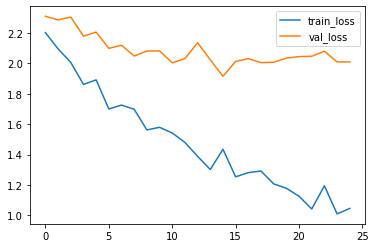

model: model1 - epochs: 10 - lr: 0.001
Run time: 15.297 min
Testing Accuracy: 0.496


In [48]:
model1_trained = train(model1, "model1", 10, 0.001, "cuda", trainloader , validloader)
test(model1_trained, testloader)

In [47]:
test(model1_trained, testloader)

Testing Accuracy: 0.378
